# RAG Workshop: From Basic to Advanced Retrieval-Augmented Generation

## 🎯 Learning Objectives

By the end of this workshop, you will understand:

1. **What is RAG?** - Retrieval-Augmented Generation fundamentals
2. **Vector Stores** - How to store and search documents using embeddings
3. **Document Processing** - Loading, splitting, and preparing documents
4. **Query Enhancement** - Advanced techniques to improve retrieval
5. **RAG Evolution** - From basic to advanced implementations

## 🏰 Context: Curse of Strahd Campaign

This workshop uses a **Dungeons & Dragons campaign** as our data source. We'll build a RAG system that can answer questions about campaign events, characters, and story arcs. This makes the learning more engaging than typical boring corporate documents!

## 📚 What You'll Build

- **Basic RAG**: Simple question → find documents → generate answer
- **Enhanced RAG**: Query rewriting for better retrieval
- **Advanced RAG**: Query decomposition with multiple retrievals

Let's start our journey into the world of RAG! 🚀

## 🔧 Step 1: Environment Setup

Before we dive into RAG, let's set up our environment. We'll:

1. **Install Dependencies**: All required packages for our RAG system
2. **Import Core Libraries**: LangChain for RAG orchestration

**Why LangChain?** It's a popular framework that makes building RAG systems much easier by providing pre-built components for document loading, text splitting, embeddings, and chains.

In [1]:
! pip install -r ./requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🤖 Step 2: Setting Up the Language Model (LLM)

Now we'll configure our **Azure OpenAI** model. This is the "brain" of our RAG system that will:

- **Generate Answers**: Create human-like responses based on retrieved documents
- **Process Queries**: Understand and work with user questions
- **Follow Instructions**: Use our custom prompts to behave like a D&D assistant

**Key Concepts:**
- **Temperature = 0.0**: Makes responses consistent and deterministic (less creative, more factual)
- **GPT-4 Mini**: A cost-effective version of GPT-4 that's perfect for most RAG use cases

### 🧪 Testing the LLM (Without RAG)

Let's first test our LLM **without** any retrieved documents. This will show you why we need RAG!

**What to expect:** The model won't know about Milos and Ireena (characters from our D&D campaign) because they're not in its training data. This demonstrates the **knowledge cutoff problem** that RAG solves.

In [2]:
from langchain_openai import AzureChatOpenAI
import os

# Set your Azure credentials
os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://evo-bots.openai.azure.com/'
os.environ['AZURE_OPENAI_API_KEY'] = 'SECRET'
os.environ['OPENAI_API_VERSION'] = '2024-12-01-preview'
# Create the LLM
llm = AzureChatOpenAI(
            azure_deployment='gpt-4.1-mini',
            model='gpt-4.1-mini',
            temperature=0.0,
        )

messages = [("user", "What happened between Milos and Ireena?")]
response = llm.invoke(messages)
print(response)

content='Could you please provide more context about Milos and Ireena? Are they characters from a specific book, movie, game, or real-life individuals? That way, I can give you a more accurate answer.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 17, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_3dcd5944f5', 'id': 'chatcmpl-CQIt6vSuMGQYI4T3X83oJiV5rslBA', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': 

### 📋 Understanding LLM Responses

This utility function helps us see **all the information** that comes back from the LLM, not just the text response. This is useful for debugging and understanding how the model works.

**Response Components:**
- **Content**: The actual text answer
- **Additional kwargs**: Extra parameters or metadata
- **Response metadata**: Information about the model, tokens used, etc.

In [3]:
def pretty_print_response(response):
    """Prints the response in a readable format."""
    print("Response:", response.content)
    print("Additional args", response.additional_kwargs)
    print("Metadata:", response.response_metadata)

pretty_print_response(response)

Response: Could you please provide more context about Milos and Ireena? Are they characters from a specific book, movie, game, or real-life individuals? That way, I can give you a more accurate answer.
Additional args {'refusal': None}
Metadata: {'token_usage': {'completion_tokens': 44, 'prompt_tokens': 17, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_3dcd5944f5', 'id': 'chatcmpl-CQIt6vSuMGQYI4T3X83oJiV5rslBA', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'se

## 🔢 Step 3: Understanding Embeddings - The Magic Behind Vector Search

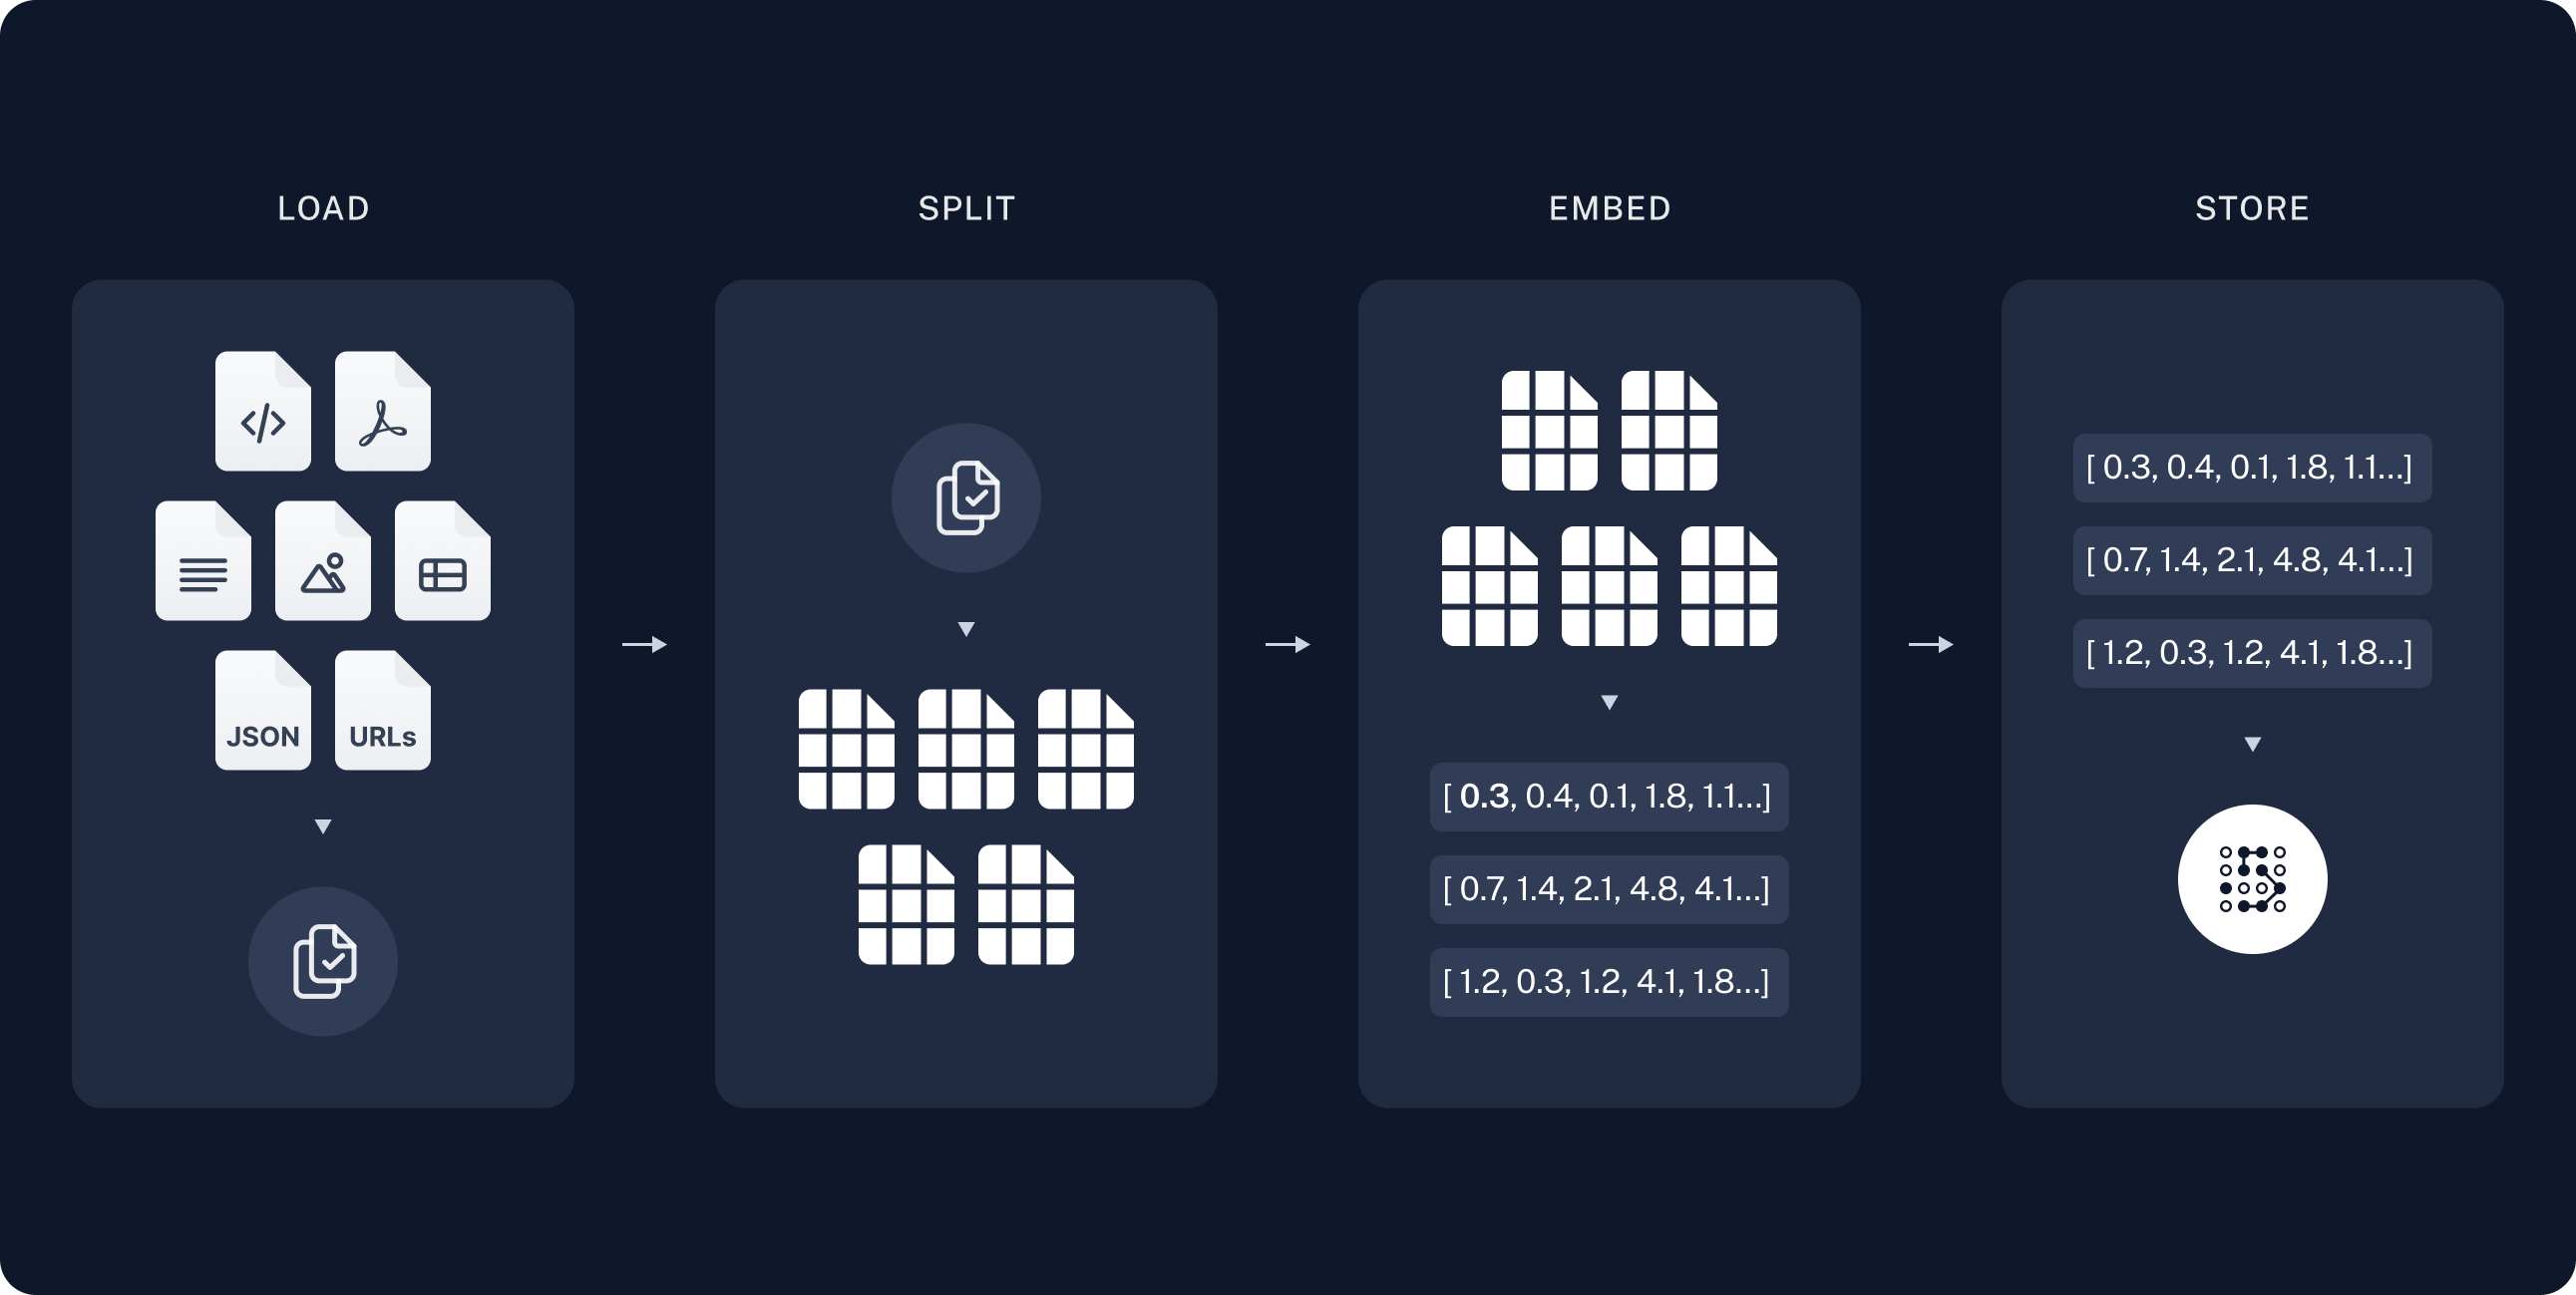

**What are embeddings?** Think of them as "DNA for text" - they convert words and sentences into numbers (vectors) that capture their meaning.

### 🧠 How Embeddings Work:
1. **Text → Numbers**: "The knight fought bravely" becomes [0.2, -0.1, 0.8, 0.3, ...]
2. **Similar Meaning → Similar Numbers**: Related concepts cluster together in vector space
3. **Searchable**: We can find similar documents by comparing these numbers

**Why Azure OpenAI Embeddings?** They're trained on massive datasets and understand context, synonyms, and relationships between concepts much better than simple keyword matching.

### 💡 Real Example:
- "What happened to Ireena?" 
- "Tell me about Ireena's fate"
- "Ireena's story"

All these have similar embeddings even though they use different words!

In [4]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="embed-new"
)

## 📚 Step 4: Loading Documents - Feeding Knowledge to Our RAG System

Time to load our **knowledge base**! We're using Curse of Strahd campaign notes as our data source.

### 🔍 What's Happening:
1. **DirectoryLoader**: Scans the `docs/` folder for all Markdown files
2. **UnstructuredMarkdownLoader**: Knows how to read Markdown files and preserve structure
3. **Glob Pattern**: `**/*.md` means "find all .md files in any subdirectory"

### 📖 Our Data Structure:
```
docs/
└── Curse of Strahd.md  (Contains campaign notes, character interactions, plot events)
└── History of Barovia.md  (Historical context, important locations)
└── Lore of Barovia.md  (Myths, legends, and background information)
└── Strahd von Zarovich.md  (Character profile, motivations, and backstory)

```

**Why Markdown?** It's human-readable, maintains structure (headers, lists), and is easy to process programmatically.

In [5]:
from langchain_community.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader

loader = DirectoryLoader("docs/", glob="**/*.md", loader_cls=UnstructuredMarkdownLoader)
docs = loader.load()
len(docs)

4

## ✂️ Step 5: Text Splitting - Breaking Documents into Digestible Chunks

**Why split documents?** Large documents are like trying to eat a whole pizza at once - it's overwhelming and ineffective!

### 🍕 The Chunking Strategy:
- **Chunk Size: 2000 characters** - Sweet spot for context without overwhelming the LLM
- **Overlap: 100 characters** - Ensures we don't lose context at chunk boundaries
- **Recursive Splitting** - Tries to split on natural boundaries (paragraphs, sentences, words)

### 🧩 How RecursiveCharacterTextSplitter Works:
1. Try to split on double newlines (paragraphs)
2. If still too big, split on single newlines (sentences)
3. If still too big, split on spaces (words)
4. Last resort: split by characters

### 💡 Why This Matters:
- **Better Retrieval**: Smaller, focused chunks are easier to match with queries
- **LLM Context Limits**: Most models have token limits
- **Relevance**: You get the exact information you need, not the whole document

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)

splits = text_splitter.split_documents(docs)
len(splits)

528

## 🗃️ Step 6: Vector Store - The Heart of Our RAG System

**What's a Vector Store?** Think of it as a super-smart database that stores documents alongside their embeddings and can find similar content lightning-fast.

### ⚡ Why Elasticsearch?
- **Scalable**: Handles millions of documents effortlessly
- **Fast**: Optimized for vector similarity search
- **Hybrid Search**: Combines semantic (meaning) and keyword search
- **Production Ready**: Used by major companies worldwide

### 🔧 Configuration Breakdown:
- **es_url**: Where our Elasticsearch instance is running (localhost)
- **index_name**: Like a database table name for our documents
- **embedding**: The embedding model we set up earlier
- **es_user/es_password**: Authentication credentials
- **verify_certs: False**: For development (disable SSL verification)

### 🎯 What Happens Next:
We'll store our document chunks WITH their embeddings, so when you ask "What happened to Ireena?", it can find all chunks that are semantically similar to your question!

In [8]:
from langchain_elasticsearch import ElasticsearchStore

ELASTIC_SEARCH_INDEX = "rag-workshop"


elastic_vector_search = ElasticsearchStore(
    es_url="https://localhost:9200/",
    index_name=ELASTIC_SEARCH_INDEX,
    embedding=embeddings,
    es_user="elastic",
    es_password="1*ExqA*Zvl*Mz25uBxud",
    es_params={"verify_certs": False}
)

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### 📥 Indexing Documents - Building Our Knowledge Base

This is where the magic happens! We're about to:

1. **Generate Embeddings**: Convert each text chunk to vectors using Azure OpenAI
2. **Store Everything**: Save both the original text AND embeddings in Elasticsearch
3. **Build Search Index**: Create optimized structures for fast similarity search

### ⏱️ What to Expect:
- This might take a few minutes depending on document size
- Each chunk gets processed through the embedding model
- Progress might be shown as documents are indexed

**Fun Fact**: After this step, you can search for "vampire lord" and it might find chunks mentioning "Strahd" even if they don't contain the exact words!

In [9]:
elastic_vector_search.add_documents(splits)

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


['61e91b55-ad7a-4704-aa71-c64c4a3d03a7',
 '84c89e21-eabe-4e5c-bf6d-6cc2beeb2f82',
 'aef4c63a-08b1-4d76-8c6a-69df0efca38a',
 '8e5f30b3-0ef7-4ddb-a760-69087e78976c',
 'b7ef63e4-1014-4e00-8650-97e407a82be7',
 '45d31277-4e60-421a-95be-e5e1b3edf056',
 'd7223ec8-6c21-4e4b-9aca-0a3dd87f18dd',
 'f7bf00ef-3019-4828-b630-4324eb117ebd',
 '4e898f00-cd67-4974-990c-8034bb01ce38',
 '5931dd57-b102-43d0-a5fc-ee769a835bd1',
 '174ab250-ded0-4a6b-b136-1a84606a1177',
 '3d094f53-ea71-479c-a74b-4357a091d12f',
 '4d5db23a-1fa3-4daf-a294-60c1a628d358',
 '4428cf58-3273-4827-a1f0-499d008f0ce8',
 'fda8d23b-9f6f-499f-814e-b2fe8007a583',
 'f16d2ace-b2ca-473c-bc61-5604e6cb6c09',
 '845ef36f-2e99-4bf4-b216-4f69d8ab4153',
 'f10c2ce4-a3ec-4d8b-87ac-e158d16c2582',
 'fced3841-c2d4-4abd-bec6-e4f526f1ed9b',
 '1324b7fe-3c9f-452c-8373-f7183bb5d517',
 '6102c061-5848-4990-bf34-43123737ca31',
 '4bde4780-5aae-4f7b-9f6a-02b180b37e8c',
 '8ff20a89-9315-4193-ad65-4b5dff2137c8',
 'ee20d546-26f2-4bc2-8f93-01766de5e858',
 'd119d745-9419-

## 🔍 Step 7: Creating a Retriever - Your Document Detective

**What's a Retriever?** It's like a detective that can find the most relevant documents for any question you ask.

### 🎯 Configuration:
- **k=3**: Return the top 3 most similar documents
- **Similarity Search**: Uses cosine similarity between query and document embeddings

### 🔬 How It Works:
1. **Your Question**: "What happened between Milos and Ireena?"
2. **Query Embedding**: Converts your question to a vector
3. **Similarity Search**: Compares your query vector to all document vectors
4. **Top Results**: Returns the 3 most similar document chunks

Let's test it and see what documents it finds!

In [11]:
retriever = elastic_vector_search.as_retriever(search_kwargs={"k": 3})

### 🧪 Testing Our Retriever

Let's see what documents our retriever finds for the question "What happened between Milos and Ireena?"

**What to look for:**
- How many documents were retrieved?
- Do they seem relevant to the question?
- What kind of content is in each document?

In [12]:
docs = retriever.get_relevant_documents("What happened between Milos and Ireena?")
len(docs)

C:\Users\David\AppData\Local\Temp\ipykernel_46088\866813821.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("What happened between Milos and Ireena?")
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


3

### 📖 Examining Retrieved Documents

This will show you the actual content of the documents that were retrieved. Pay attention to:

- **page_content**: The actual text content
- **metadata**: Information about the source file, chunk position, etc.
- **Relevance**: How well does each document match our question?

This is the raw material that will be fed to our LLM to generate the final answer!

In [13]:
docs

[Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content="Meanwhile, Ireena attempts to strike up a conversation with Ez. Though well-intentioned, she soon discovers that Ez’s manner is blunt and unfiltered. Ez speaks her mind without hesitation—not out of cruelty, but because she doesn’t pause to consider how her words may land. The attempt at connection falters under the weight of Ez’s stark honesty.\n\nIreena approaches Milos with a heavy heart, seeking clarity after the overwhelming truths revealed during the vision within the Tome. She asks whether he managed to catch Tatyana when he leapt after her. Milos confirms that he did—and that Tatyana recognized him as Sergei.\n\nShe then presses further, asking what his feelings for her truly mean, especially since he had confessed his love before learning he was Sergei. Milos answers simply: he loves her. He always has, since childhood, long before his transformation into a vampire. Ireena admits that she can’t deny the e

## 🎭 Step 8: Crafting the Perfect RAG Prompt

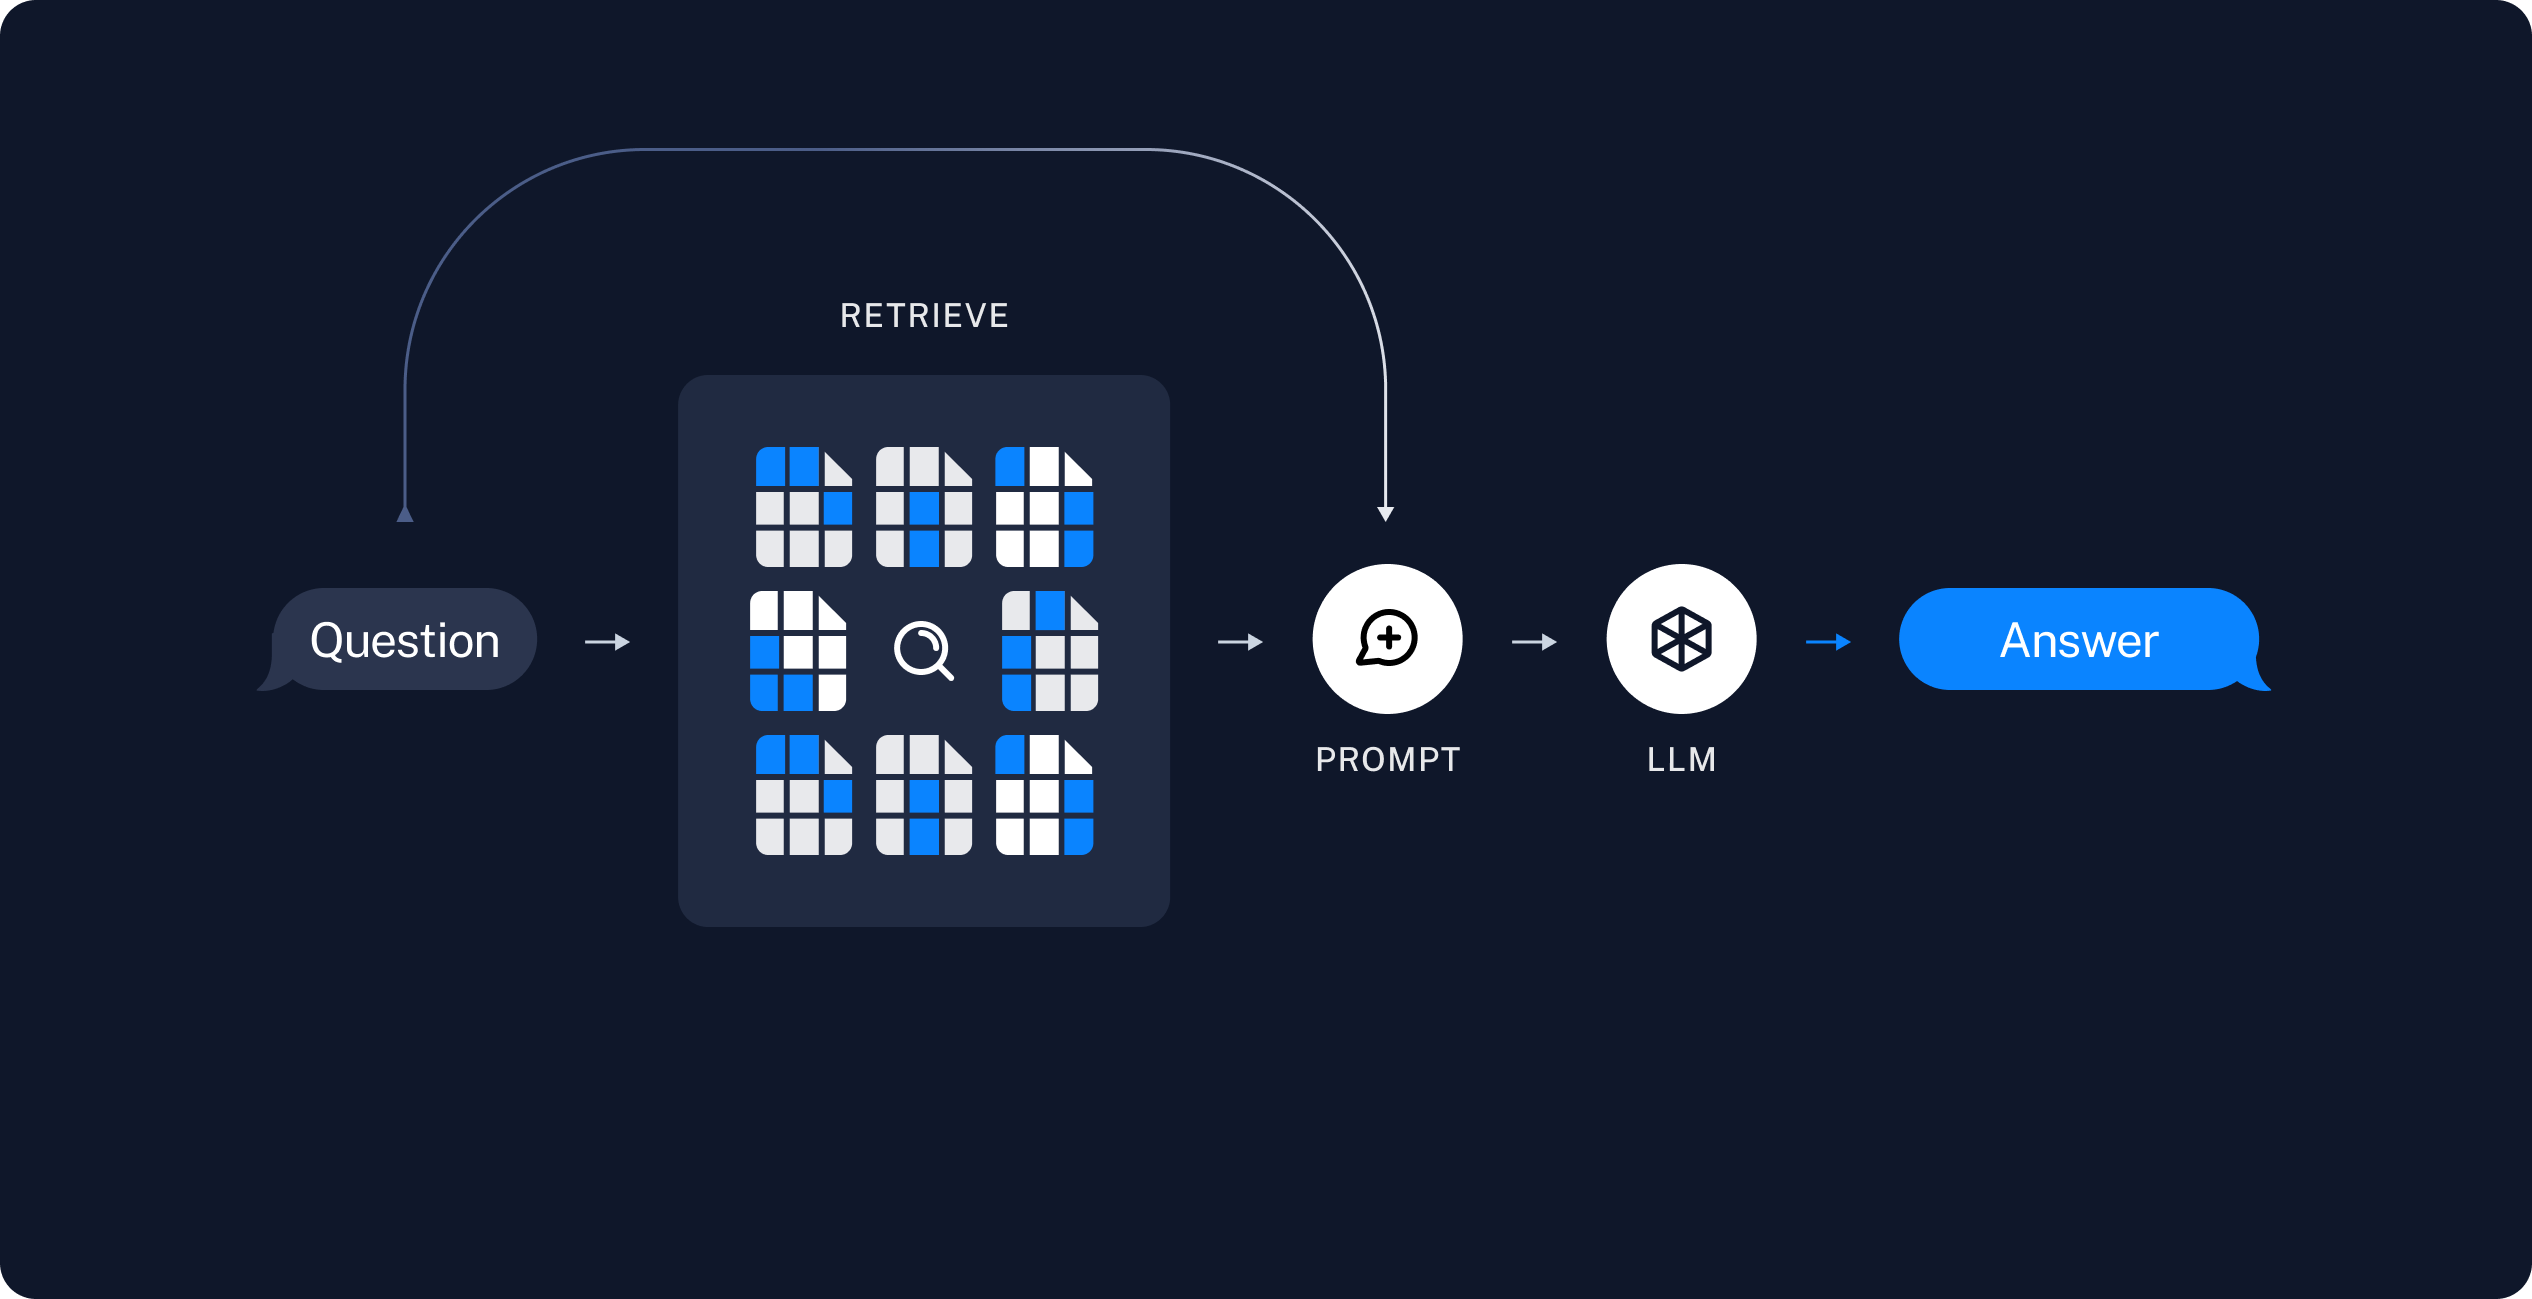

**Why Custom Prompts Matter**: The prompt is like giving instructions to a human assistant. Good prompts = better answers!

### 🎯 Our Prompt Strategy:
1. **Role Definition**: "You are a Dungeon Master's assistant" - sets context
2. **Task Clarity**: Explains what the context is and how to use it
3. **Constraints**: "Don't make up answers" - prevents hallucination
4. **Response Format**: "Limit to 5 sentences" - keeps answers focused
5. **Personality**: "Thanks for asking!" - adds character

### 💡 Prompt Engineering Tips:
- **Be Specific**: Clear instructions produce better results
- **Set Boundaries**: Tell the model what NOT to do
- **Add Context**: Help the model understand its role
- **Format Expectations**: Specify desired output format

This prompt will transform raw document chunks into helpful, accurate answers!

In [14]:

from langchain_core.prompts import PromptTemplate

template = """You are Dungeon Master's assistant for the Curse of Strahd campaign.
The context you will receive will be pieces of information taken from the notes taken after every session.
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Include all relevant information but limit the response to 5 sentences.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

### 🔧 Document Formatting Helper

This simple but crucial function takes our retrieved documents and formats them for the LLM:

- **Combines Multiple Docs**: Joins all retrieved documents into one context
- **Clean Separation**: Uses `\n\n` to clearly separate different documents
- **Context Preparation**: Prepares the "context" variable for our prompt template

Without this, we'd just have a list of document objects. With it, we have clean, formatted text that the LLM can understand and use!

In [15]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## ⛓️ Step 9: Building the Complete RAG Chain

**This is where everything comes together!** We're building a processing pipeline that:

### 🔄 The RAG Chain Flow:
1. **Input**: User question (e.g., "What happened between Milos and Ireena?")
2. **Retrieve**: `retriever` finds relevant documents
3. **Format**: `format_docs` prepares them for the LLM
4. **Prompt**: `custom_rag_prompt` creates the final prompt with context
5. **Generate**: `llm` creates the answer
6. **Parse**: `StrOutputParser` extracts just the text response

### 🧩 LangChain Magic:
- **`|` Symbol**: Chains components together (like Unix pipes)
- **`RunnablePassthrough()`**: Passes the original question through unchanged
- **Dictionary Structure**: Provides both `context` and `question` to the prompt

**Result**: A complete RAG system in just a few lines of code!

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | custom_rag_prompt
        | llm
        | StrOutputParser()
)

### 🎉 Testing Our Basic RAG System!

**The Moment of Truth!** Let's test our complete RAG system with the same question we asked the LLM earlier.

**Compare the results:**
- **Before RAG**: Model didn't know about Milos and Ireena
- **After RAG**: Model should provide specific information from our campaign notes

**What to expect:**
- A focused, relevant answer based on retrieved documents
- Information that wasn't in the model's training data
- The signature "thanks for asking!" at the end

This demonstrates the **core power of RAG**: extending AI knowledge with your own data!

In [17]:
rag_chain.invoke("What happened between Milos and Ireena?")

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'Milos and Ireena shared a deeply emotional and honest conversation about their complicated feelings, the nature of Milos’s vampirism, and their intertwined pasts as echoes of Sergei and Tatyana. They agreed to see each other as individuals rather than reflections of their former selves, acknowledging the difficulty in untangling genuine emotions from fate or manipulation by the Dark Powers. Milos confessed his love for Ireena, which he claims has existed since childhood, and she admitted to feeling emotions but remains uncertain about their clarity. They made a pact to support each other in becoming better people, despite the burdens they carry. The moment culminated in a tender dance and a comforting embrace, symbolizing a fragile but hopeful connection. Thanks for asking!'

## 🚀 Step 10: Enhanced RAG - Query Rewriting

**Problem**: Sometimes users ask questions in ways that don't match how information is stored in documents.

**Solution**: **Query Rewriting** - Transform user queries into better search terms!

### 🔄 How Query Rewriting Works:
1. **User Question**: "What are Sally's abilities?" (might be too vague)
2. **LLM Rewriting**: "What are Sally's magical powers, combat skills, and special abilities in the Curse of Strahd campaign?"
3. **Better Retrieval**: More specific query = better document matches
4. **Better Answers**: More relevant context = higher quality responses

### 💡 Why This Helps:
- **Bridges Language Gap**: User casual language → Document formal language
- **Adds Context**: Includes domain-specific terms (D&D, Curse of Strahd)
- **Improves Specificity**: Vague questions become detailed queries
- **Better Matching**: Embedding similarity improves with better queries

In [18]:
rewrite_template = """Rewrite the provided user query to be optimized for RAG retrieval knowing the user query is related to a Curse of Strahd campaign and what happened during the campaign.
Make sure it's detailed enough to facilitate retrieval of data from the vector store.

User query: {question}

Rewritten user query:"""
rewrite_query_prompt = PromptTemplate.from_template(rewrite_template)

# Advanced RAG Implementation with Multiple Techniques

This notebook demonstrates three levels of RAG (Retrieval Augmented Generation) implementation:

1. **Basic RAG**: Simple query → retrieve documents → generate answer
2. **Enhanced RAG**: Query rewriting → retrieve documents → generate answer
3. **Advanced RAG**: Query decomposition → multiple retrievals → deduplicate → generate answer

The advanced RAG implementation breaks down complex queries into multiple sub-questions, retrieves documents for each sub-question, deduplicates the results, and then generates a comprehensive answer.

### 🧪 Testing Query Rewriting

Let's see how our query rewriting system transforms user questions into better search queries.

**Original vs Rewritten**: Notice how the rewritten query:
- Adds relevant context (D&D, Curse of Strahd)
- Uses more specific terminology
- Provides better search targets for our vector store

In [19]:
# Create a query rewriting step
rewrite_chain = rewrite_query_prompt | llm | StrOutputParser()

# Test the rewrite chain
original_query = "What happened between Milos and Ireena?"
rewritten_query = rewrite_chain.invoke({"question": original_query})
print(f"Original: {original_query}")
print(f"Rewritten: {rewritten_query}")

Original: What happened between Milos and Ireena?
Rewritten: In the Curse of Strahd campaign, what are the key events and interactions that occurred between the characters Milos and Ireena? Please provide detailed information about their relationship, significant encounters, conflicts, or developments involving these two characters throughout the storyline.


### 🔗 Building the Enhanced RAG Chain

Now we're creating an **enhanced RAG system** that automatically rewrites queries before retrieval:

**Enhanced Flow:**
1. **User Query** → 2. **Query Rewriting** → 3. **Document Retrieval** → 4. **Answer Generation**

**Key Changes:**
- `enhanced_retriever()`: First rewrites the query, then retrieves documents
- `lambda query:`: Anonymous function that processes the query through our enhancement pipeline

**Benefits:**
- Automatic query optimization
- No extra work for users
- Better retrieval results
- More accurate answers

In [20]:
# Create the enhanced RAG chain with query rewriting
def enhanced_retriever(query):
    # First rewrite the query
    rewritten_query = rewrite_chain.invoke({"question": query})
    # Then use the rewritten query to retrieve documents
    return retriever.get_relevant_documents(rewritten_query)

# Build the complete RAG chain with query rewriting
enhanced_rag_chain = (
    {
        "context": lambda query: format_docs(enhanced_retriever(query)),
        "question": RunnablePassthrough()
    }
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

### 🏁 Enhanced vs Basic RAG Comparison

Let's compare our **Enhanced RAG** (with query rewriting) against our **Basic RAG** system:

**What to Look For:**
- **Answer Quality**: Are the enhanced answers more detailed or accurate?
- **Relevance**: Does enhanced RAG find better source material?
- **Completeness**: Does query rewriting help find more comprehensive information?

**Expected Results:**
- Enhanced RAG should provide more contextual and complete answers
- The rewritten query should retrieve more relevant documents
- Overall answer quality should improve significantly

In [24]:
# Test the enhanced RAG chain
query = "What are Sally's abilities?"
print("Testing enhanced RAG chain with query rewriting:")
enhanced_response = enhanced_rag_chain.invoke(query)
print(enhanced_response)

# Compare with the original chain
print("\nComparing with original RAG chain:")
original_response = rag_chain.invoke(query)
print(original_response)

Testing enhanced RAG chain with query rewriting:


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Sally has the ability to transform into a spider, as demonstrated when she investigates the inn in her spider form. She also has a mysterious black wound above her right shoulder that sometimes oozes smoke and never fully heals, a remnant of a traumatic attack by a living shadow that scarred her emotionally and physically. Additionally, she receives visions through a raven, which show her prophetic and symbolic scenes involving Strahd and other key figures, suggesting a connection to magical or spiritual insight. Her upbringing among druids and nature-loving people implies she may have some affinity with nature or druidic magic, though this is not explicitly detailed. Thanks for asking!

Comparing with original RAG chain:


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Sally has a strong connection to nature, allowing her to summon and transform into powerful animals such as a majestic elk and a giant eagle, which she uses both in combat and for travel. She can also manifest radiant soul wings that glow with divine light, enabling her to engage in aerial battles with celestial power. Unlike others who seek divine intervention, Sally's magic is described as different—more self-reliant and deeply tied to the natural world rather than gods. She has the ability to sense and communicate with nature on a profound level, as shown when she listens to the dying tree and perceives its suffering and the parasites within. This connection suggests a druidic or nature-based magic that requires true empathy and understanding rather than surface-level interaction. Thanks for asking!


## 🎓 Step 11: Advanced RAG - Query Decomposition

**The Problem**: Complex questions often need information from multiple sources. Single queries might miss important context.

**The Solution**: **Query Decomposition** - Break complex questions into multiple focused sub-questions!

### 🧩 How Query Decomposition Works:

1. **Complex Question**: "What are key moments between Ziva and Milos?"
2. **Decompose**: Break into 3-5 focused sub-questions:
   - "Who is Ziva in the Curse of Strahd campaign?"
   - "Who is Milos and what role does he play?"
   - "What interactions occurred between Ziva and Milos?"
   - "What significant events involved both characters?"
3. **Multi-Retrieval**: Search documents for each sub-question
4. **Deduplicate**: Remove duplicate documents
5. **Comprehensive Answer**: Generate response with broader context

### 🎯 Benefits:
- **Comprehensive Coverage**: Captures multiple aspects of complex questions
- **Better Context**: More diverse document retrieval
- **Reduced Blind Spots**: Harder to miss relevant information
- **Robust Answers**: Well-rounded responses to nuanced queries

In [25]:
from typing import List

# Create a prompt for decomposing the query into multiple sub-questions
decompose_query_template = """Break down the following question into 3-5 clear and simple sub-questions that would help gather relevant information to answer the main question comprehensively knowing the main question is related to a Curse of Strahd D&D campaign and what happened during that campaign.
Think step-by-step about what information would be needed to provide a complete answer.

Main question: {question}

Generate 3-5 sub-questions, each on a new line, prefixed with "Q: ".
Do not number the questions, just prefix with Q:.

Sub-questions:"""

decompose_query_prompt = PromptTemplate.from_template(decompose_query_template)

# Chain to decompose a query into multiple sub-questions
decompose_chain = decompose_query_prompt | llm | StrOutputParser()

### 🔍 Multi-Query Retrieval Implementation

This is the **heart of our Advanced RAG system**. Here's what this complex function does:

### 🔄 Step-by-Step Process:

1. **Query Decomposition**: 
   - Takes complex question and breaks it into 3-5 sub-questions
   - Each sub-question focuses on a specific aspect

2. **Enhanced Retrieval**: 
   - For each sub-question, first rewrites it (query enhancement)
   - Then retrieves relevant documents
   - Combines benefits of both enhancement techniques

3. **Document Collection**: 
   - Gathers all documents from all sub-queries
   - Results in a comprehensive document pool

4. **Deduplication**: 
   - Removes duplicate documents (using first 100 characters as key)
   - Prevents redundant information in final context

5. **Optimization**: 
   - Limits to maximum documents (default 8) to stay within LLM context limits
   - Returns most relevant, non-duplicate documents

**Result**: A rich, diverse set of documents that covers multiple aspects of the original complex question!

In [26]:
# Function to parse sub-questions from the decompose chain output
def parse_sub_questions(decompose_output: str) -> List[str]:
    """Parse the output from the decompose chain into a list of sub-questions."""
    lines = decompose_output.strip().split('\n')
    questions = [line[3:].strip() for line in lines if line.startswith('Q:')]
    return questions

# Function to retrieve documents for a list of questions and combine results
def multi_query_retriever(query: str, max_docs: int = 8) -> List:
    """
    Break down a query into sub-questions, retrieve documents for each, and combine results.

    Args:
        query: The main user query
        max_docs: Maximum number of documents to return (after deduplication)

    Returns:
        List of retrieved documents
    """
    # Decompose the main query into sub-questions
    decomposed_output = decompose_chain.invoke({"question": query})
    sub_questions = parse_sub_questions(decomposed_output)

    print(f"Main query: {query}")
    print(f"Decomposed into {len(sub_questions)} sub-questions:")
    for i, q in enumerate(sub_questions):
        print(f"{i+1}. {q}")

    # Retrieve documents for each sub-question
    all_docs = []
    for sub_q in sub_questions:
        # Option 1: Use the original retriever
        # docs = retriever.get_relevant_documents(sub_q)

        # Option 2: Use the enhanced retriever with query rewriting
        rewritten_sub_q = rewrite_chain.invoke({"question": sub_q})
        docs = retriever.get_relevant_documents(rewritten_sub_q)

        print(f"Retrieved {len(docs)} docs for: '{sub_q}'")
        all_docs.extend(docs)

    # Deduplicate documents based on document content
    unique_docs = []
    unique_contents = set()

    for doc in all_docs:
        # Use the first 100 chars as a simple deduplication key
        # In a production system, you'd want a more robust deduplication strategy
        content_key = doc.page_content[:100]
        if content_key not in unique_contents:
            unique_contents.add(content_key)
            unique_docs.append(doc)

    print(f"Total documents before deduplication: {len(all_docs)}")
    print(f"Total documents after deduplication: {len(unique_docs)}")

    # Limit to max_docs
    final_docs = unique_docs[:max_docs] if len(unique_docs) > max_docs else unique_docs
    print(f"Returning {len(final_docs)} documents")

    return final_docs

### ⛓️ Advanced RAG Chain Assembly

Creating our most sophisticated RAG system yet! This chain combines:

**All Three Techniques:**
1. **Query Decomposition**: Breaks complex questions into focused sub-questions
2. **Query Rewriting**: Optimizes each sub-question for better retrieval
3. **Multi-Document Retrieval**: Gathers comprehensive context from multiple searches

**Complete Flow:**
User Question → Decompose → Rewrite Sub-Questions → Multi-Retrieval → Deduplicate → Format → Generate Answer

This represents the **state-of-the-art** in RAG systems!

In [27]:
# Create the advanced RAG chain with query decomposition
advanced_rag_chain = (
    {
        "context": lambda query: format_docs(multi_query_retriever(query)),
        "question": RunnablePassthrough()
    }
    | custom_rag_prompt
    | llm
    | StrOutputParser()
)

## 🏆 The Ultimate RAG Showdown!

Time for the **final comparison**! We'll test all three RAG implementations with the same complex question:

### 🥊 The Contestants:

1. **🥉 Basic RAG**: Simple query → retrieve → answer
2. **🥈 Enhanced RAG**: Query rewriting → retrieve → answer  
3. **🥇 Advanced RAG**: Query decomposition → multiple rewrites → multi-retrieve → deduplicate → answer

### 📊 What to Compare:

- **Answer Completeness**: Which provides the most comprehensive response?
- **Information Quality**: Which finds the most relevant details?
- **Processing Transparency**: Notice how Advanced RAG shows its thinking process
- **Context Richness**: Which system gathers the best supporting evidence?

**Hypothesis**: Advanced RAG should provide the most complete and nuanced answer because it:
- Considers multiple aspects of the question
- Retrieves more diverse documents
- Combines information from various sources

Let's see the results! 🎬

In [28]:
# Test the advanced RAG chain with query decomposition
complex_query = "What are key moments between Ziva and Milos?"

print("TESTING ADVANCED RAG CHAIN WITH QUERY DECOMPOSITION:")
advanced_response = advanced_rag_chain.invoke(complex_query)
print("\nAdvanced RAG Chain Response:")
print(advanced_response)

print("\n" + "-"*50)

print("\nCOMPARING WITH ENHANCED RAG CHAIN:")
enhanced_response = enhanced_rag_chain.invoke(complex_query)
print("\nEnhanced RAG Chain Response (with query rewriting only):")
print(enhanced_response)

print("\n" + "-"*50)

print("\nCOMPARING WITH ORIGINAL RAG CHAIN:")
original_response = rag_chain.invoke(complex_query)
print("\nOriginal RAG Chain Response:")
print(original_response)

TESTING ADVANCED RAG CHAIN WITH QUERY DECOMPOSITION:
Main query: What are key moments between Ziva and Milos?
Decomposed into 5 sub-questions:
1. What are the backgrounds and motivations of Ziva and Milos in the Curse of Strahd campaign?
2. How did Ziva and Milos first meet and what was their initial relationship like?
3. What significant events or challenges did Ziva and Milos face together during the campaign?
4. Were there any turning points or conflicts between Ziva and Milos that affected their relationship?
5. How did the interactions between Ziva and Milos influence the overall story or outcome of the campaign?


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 3 docs for: 'What are the backgrounds and motivations of Ziva and Milos in the Curse of Strahd campaign?'


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 3 docs for: 'How did Ziva and Milos first meet and what was their initial relationship like?'


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 3 docs for: 'What significant events or challenges did Ziva and Milos face together during the campaign?'


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 3 docs for: 'Were there any turning points or conflicts between Ziva and Milos that affected their relationship?'


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 3 docs for: 'How did the interactions between Ziva and Milos influence the overall story or outcome of the campaign?'
Total documents before deduplication: 15
Total documents after deduplication: 7
Returning 7 documents

Advanced RAG Chain Response:
Key moments between Ziva and Milos include their complex dynamic where Ziva considers making a move on Milos despite his many red flags, while Milos no longer has romantic feelings for Ireena but still shares a connection with her. They share conversations about faith and the Morninglord, with Ziva encouraging Milos to find his own spiritual clarity despite Barovia’s darkness. Their relationship is tested when Milos angrily confronts Ziva over her decision to feed Doru, blaming her for empowering a threat that led to death, highlighting their conflicting views on mercy and consequence. Ziva admits liking Milos as a person but denies romantic feelings, while Milos sees the group mostly as tools, trusting only Ireena, and warns he w

C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Enhanced RAG Chain Response (with query rewriting only):
Key moments between Ziva and Milos include Ziva expressing interest in making a move on Milos despite acknowledging his complicated nature and red flags, showing her intrigue in him beyond just friendship. Ziva and Sergei bond over their shared frustrations with noble courts and their devotion to the Morninglord, indirectly connecting to Milos’s story. Arabelle wonders if Milos might leave Moonshade to stay with her, and Ziva admits this is possible, highlighting Milos’s complex relationships. When pressed about her feelings for Milos, Ziva admits she likes him as a person but denies any romantic feelings, indicating a nuanced connection. Overall, their interactions reveal tension, curiosity, and complicated emotions without clear romantic commitment. Thanks for asking!

--------------------------------------------------

COMPARING WITH ORIGINAL RAG CHAIN:


C:\Projects\evo-rag\Evo-rag-workshop\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Original RAG Chain Response:
Key moments between Ziva and Milos include their shared experience at the cave where Milos’s mother’s body was found, highlighting a place of emotional significance for both. Milos invites Ziva to train with him, and they spend an hour swimming in the frozen lake together, showing a moment of quiet companionship. Ziva reveals her complicated past involving a childhood crush and betrayal, which adds depth to her character and hints at why she might be drawn to Milos despite complications. She also expresses interest in making a move on Milos, intrigued by his complexity, though she acknowledges the situation is already complicated. Finally, Ziva admits to liking Milos as a person but denies romantic feelings, while also supporting Arabelle’s thoughts about Milos’s potential future choices. Thanks for asking!


## 🎓 Workshop Conclusion: Your RAG Journey

Congratulations! You've built and understood three levels of RAG systems. Let's recap what you've learned:

### 🚀 Your RAG Evolution:

#### 1. **Basic RAG** - The Foundation
- ✅ **Core Concept**: Retrieve documents → Generate answers
- ✅ **Vector Embeddings**: Convert text to searchable numbers
- ✅ **Similarity Search**: Find relevant content automatically
- ✅ **Prompt Engineering**: Craft effective instructions for LLMs

#### 2. **Enhanced RAG** - Query Optimization
- ✅ **Query Rewriting**: Transform user questions for better retrieval
- ✅ **Domain Context**: Add specialized knowledge to queries
- ✅ **Improved Matching**: Better queries = better document retrieval

#### 3. **Advanced RAG** - Multi-Dimensional Retrieval
- ✅ **Query Decomposition**: Break complex questions into focused parts
- ✅ **Multi-Retrieval**: Search multiple aspects simultaneously
- ✅ **Deduplication**: Optimize document selection
- ✅ **Comprehensive Answers**: Rich, nuanced responses

### 🎯 Key Takeaways for Real-World Applications:

1. **Start Simple**: Basic RAG solves 80% of use cases effectively
2. **Iterate & Improve**: Add complexity only when needed
3. **Domain Knowledge Matters**: Custom prompts and context are crucial
4. **Quality Over Quantity**: Better retrieval > more documents
5. **User Experience**: Complex systems should feel simple to users

### 🚀 Next Steps in Your RAG Journey:

- **Experiment with Different Embedding Models**: Try domain-specific embeddings
- **Explore Hybrid Search**: Combine semantic + keyword search
- **Add Evaluation Metrics**: Measure and improve your RAG system
- **Consider Production Concerns**: Scaling, latency, cost optimization
- **Advanced Techniques**: Graph RAG, Agentic RAG, Multi-modal RAG

### 📚 Production Considerations:

- **Cost Management**: Embedding and LLM API calls add up
- **Latency Optimization**: Users expect fast responses
- **Data Privacy**: Ensure sensitive information is handled properly
- **Evaluation & Monitoring**: Continuously measure and improve performance

**Remember**: The best RAG system is the one that solves your users' problems effectively and efficiently. Start with the basics, understand your users' needs, then evolve your system accordingly.

Thanks for joining this RAG workshop! 🎉